In [88]:
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model
from keras.utils import to_categorical
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords

sns.set(color_codes=True)
%matplotlib inline

In [121]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 30

In [15]:
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('../large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
    # is just a space-separated text file in the format:
    # word vec[0] vec[1] vec[2] ...
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))


Loading word vectors...
Found 400000 word vectors.


In [16]:
filename = '../large_files/spam.csv'
df = pd.read_csv(filename, encoding='latin-1')
df.columns = ['label', 'text', 'v3', 'v4', 'v5']
df = df.drop(['v3','v4','v5'],axis=1)
df.dropna()
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [28]:
def process_label(label):
    if label == 'ham':
        return 1
    else:
        return 2
    
df['label'] = df['label'].apply(process_label)
df.head()

,label,text
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,2,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he goes to usf, he lives aro..."


In [68]:
def text_process(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [71]:
text = df['text'].copy()
text_feat = text.apply(text_process)

In [135]:
# prepare text samples and their labels
print('Loading in comments...')
sentences = text_feat.values
targets = to_categorical(df["label"].values)


targets

Loading in comments...


array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [136]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

sequences[:2]

[[9,
  4243,
  685,
  603,
  570,
  1131,
  38,
  58,
  259,
  1132,
  81,
  2773,
  1133,
  15,
  4244,
  68],
 [10, 220, 1283, 342, 1, 1716]]

In [137]:
print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])

max sequence length: 80
min sequence length: 0
median sequence length: 7


In [138]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 9431 unique tokens.


In [140]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.2, random_state=111)

print('Shape of data tensor:', data.shape)

Shape of data tensor: (5572, 100)


In [142]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all zeros.
            embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [143]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [144]:
# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [145]:
%%time
print('Training model...')
r = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=25,
    validation_split=VALIDATION_SPLIT
)

Training model...
Train on 3565 samples, validate on 892 samples
Epoch 1/25
3565/3565 [==============================] - 2s 551us/step - loss: 0.4287 - acc: 0.8718 - val_loss: 0.3907 - val_acc: 0.8857
Epoch 2/25
3565/3565 [==============================] - 1s 344us/step - loss: 0.1939 - acc: 0.9534 - val_loss: 0.1796 - val_acc: 0.9518
Epoch 3/25
3565/3565 [==============================] - 1s 353us/step - loss: 0.1297 - acc: 0.9647 - val_loss: 0.1369 - val_acc: 0.9619
Epoch 4/25
3565/3565 [==============================] - 1s 343us/step - loss: 0.0895 - acc: 0.9722 - val_loss: 0.1233 - val_acc: 0.9641
Epoch 5/25
3565/3565 [==============================] - 1s 376us/step - loss: 0.0694 - acc: 0.9770 - val_loss: 0.1753 - val_acc: 0.9540
Epoch 6/25
3565/3565 [==============================] - 1s 346us/step - loss: 0.0507 - acc: 0.9854 - val_loss: 0.1574 - val_acc: 0.9540
Epoch 7/25
3565/3565 [==============================] - 1s 348us/step - loss: 0.0439 - acc: 0.9871 - val_loss: 0.1402 -

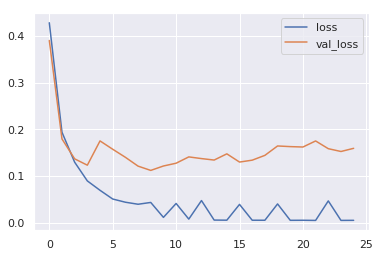

In [146]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

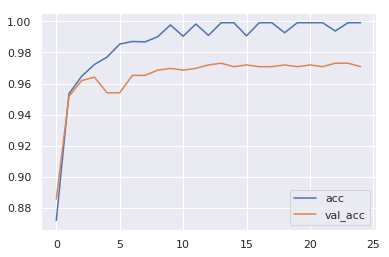

In [147]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [154]:
p = model.predict(X_test)
predicted = np.argmax(p, axis=1)
predicted


array([1, 1, 1, ..., 1, 1, 1])

In [156]:
# y_test=np.argmax(y_test, axis=1)
y_test

array([1, 1, 1, ..., 1, 1, 1])

In [158]:
from sklearn.metrics import accuracy_score

print('accuracy %s' % accuracy_score(y_test, predicted))

accuracy 0.9829596412556054
